In [1]:
%pip install -q gymnasium torch matplotlib


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Check if ur system has gpu

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# If using GPU, print some info about it
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cuda
GPU Name: NVIDIA RTX 2000 Ada Generation
GPU Memory: 16.9 GB


# Load the Environment

In [3]:
import gymnasium as gym
env = gym.make("CartPole-v1")


In [4]:
env.action_space.n == 2

True

In [5]:
state, _ = env.reset()
print("State shape:", state.shape)


State shape: (4,)


In [6]:
# Reset the environment to get initial observation
observation, info = env.reset()

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
print("Initial observation:", observation)
print("Observation shape:", observation.shape)

Observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Action space: Discrete(2)
Initial observation: [ 0.00905932 -0.01916228 -0.01231667  0.04967717]
Observation shape: (4,)


# Taking random actions over the environment

In [7]:
import gymnasium as gym
import numpy as np

env = gym.make("CartPole-v1")
observation, info = env.reset()

print("=== Taking 5 random steps ===")
for step in range(5):
    # Take a random action
    action = env.action_space.sample()  # randomly choose 0 or 1
    
    # Execute the action
    observation, reward, terminated, truncated, info = env.step(action)
    
    print(f"Step {step+1}:")
    print(f"  Action taken: {action} ({'Left' if action == 0 else 'Right'})")
    print(f"  New observation: {observation}")
    print(f"  Reward: {reward}")
    print(f"  Episode ended: {terminated or truncated}")
    print()
    
    # If episode ends, reset
    if terminated or truncated:
        print("Episode ended! Resetting...")
        observation, info = env.reset()
        break

env.close()

=== Taking 5 random steps ===
Step 1:
  Action taken: 0 (Left)
  New observation: [ 0.00240862 -0.14591084 -0.02792381  0.28404254]
  Reward: 1.0
  Episode ended: False

Step 2:
  Action taken: 1 (Right)
  New observation: [-0.0005096   0.04959802 -0.02224296 -0.01731495]
  Reward: 1.0
  Episode ended: False

Step 3:
  Action taken: 0 (Left)
  New observation: [ 0.00048236 -0.145198   -0.02258926  0.2682679 ]
  Reward: 1.0
  Episode ended: False

Step 4:
  Action taken: 0 (Left)
  New observation: [-0.0024216  -0.3399904  -0.01722391  0.5537413 ]
  Reward: 1.0
  Episode ended: False

Step 5:
  Action taken: 0 (Left)
  New observation: [-0.00922141 -0.53486633 -0.00614908  0.8409482 ]
  Reward: 1.0
  Episode ended: False



# ------------------------------------------------------------
# ✅ Deep Q-Learning Summary: What are we learning?
#
# - We are learning the Q-function: Q(s, a)
#     → Tells us: "If I take action a in state s, how much total future reward can I expect?"
#
# - The policy is not learned directly.
#     → At runtime, we pick the action with the highest Q-value:
#         policy(s) = argmax_a Q(s, a)
#
# - Goal: Learn accurate Q-values so we can act optimally by just picking the best action.
# ------------------------------------------------------------


# ------------------------------------------------------------
# 📘 Bellman Equation and Q-Value Learning (Value-Based RL)
#
# Richard Bellman introduced dynamic programming, which helps us
# solve problems recursively by using solutions to subproblems.
#
# In Q-learning, we estimate the Q-value (expected return from
# taking action 'a' in state 's') using the Bellman equation:
#
#     Q(s, a) ← r + γ * max_a' Q(s', a')
#
# Where:
# - r is the immediate reward after taking action a in state s
# - γ (gamma) is the discount factor for future rewards
# - s' is the new state after taking action a
# - max_a' Q(s', a') is the best future reward we can expect
#
# The goal: Learn good Q(s, a) values so that we can act using:
#     policy(s) = argmax_a Q(s, a)
#
# This is the foundation of Value-Based Reinforcement Learning.
# ------------------------------------------------------------

# ------------------------------------------------------------
# ❗ Why Tabular Q-Learning Doesn't Work for CartPole
#
# - The state in CartPole is a vector of 4 continuous values:
#     [position, velocity, pole angle, pole angular velocity]
#
# - There are infinitely many possible states (real numbers),
#   so we cannot build a Q-table with one row per state.
#
# ✅ Solution: Use a Deep Neural Network (DQN)
# - Input: the continuous state vector (4 floats)
# - Output: Q-values for each possible action (e.g., [Q_left, Q_right])
#
# This lets us generalize across similar states using function approximation.
# ------------------------------------------------------------


# ------------------------------------------------------------
# 🧠 Deep Q-Network (DQN) Concept
#
# - A DQN uses a neural network to approximate the Q-function:
#       Q(s, a) ≈ NN(s)[a]
#
# - Input: current state vector (e.g., 4 floats in CartPole)
# - Output: Q-values for each action (e.g., [Q_left, Q_right])
#
# - During training, we update using the Bellman target:
#       target = r + γ * max_a' Q(s', a')
#
# - Loss = (target - predicted Q(s, a))^2
#
# This allows learning over continuous state spaces using function approximation.
# ------------------------------------------------------------


# ------------------------------------------------------------
# 🧠 Simple DQN Model (Without Classes)
#
# - We build a neural network to estimate Q(s, a)
# - For CartPole:
#     Input = 4 values (state vector)
#     Output = 2 Q-values (for LEFT and RIGHT actions)
#
# - Architecture:
#     Linear layer: 4 → 128
#     ReLU activation
#     Linear layer: 128 → 2
#
# - Output: [Q(s, LEFT), Q(s, RIGHT)]
#
# This model will be trained to predict expected total return
# for each action, given a state.
# ------------------------------------------------------------


# Coding the network up front

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# Forward Pass

In [11]:
layer1 = nn.Linear(4, 128)   # Input: 4 values → Output: 128 features
layer2 = nn.Linear(128, 2)   # Input: 128 → Output: 2 Q-values (LEFT and RIGHT)
#Dummy Data
state = torch.tensor([[0.0, 0.1, 0.05, -0.02]], dtype=torch.float32)
x = layer1(state)      # Linear: 4 → 128
x = F.relu(x)          # Activation
q_values = layer2(x)   # Linear: 128 → 2
print(q_values)
action = torch.argmax(q_values, dim=1)
print(action)

tensor([[-0.0858,  0.0330]], grad_fn=<AddmmBackward0>)
tensor([1])


# ✅ Step: Epsilon-Greedy Action Selection

In [12]:
import random

def select_action(state, epsilon):
    if random.random() < epsilon:
        # Explore: take a random action (0 or 1)
        return torch.tensor([random.randint(0, 1)])
    else:
        # Exploit: take action with highest Q-value
        x = layer1(state)
        x = F.relu(x)
        q_values = layer2(x)
        return torch.argmax(q_values, dim=1)

# Example use
state = torch.tensor([[0.0, 0.1, 0.05, -0.02]], dtype=torch.float32)
action = select_action(state, epsilon=0.1)
print(action)


tensor([1])


# # ✅ Minimal Replay Buffer (Python list version)


In [13]:

replay_buffer = []  # empty list to store transitions

def store_transition(state, action, reward, next_state, done):
    transition = (state, action, reward, next_state, done)
    replay_buffer.append(transition)


# Sample Batch

In [14]:
import random

def sample_batch(batch_size):
    return random.sample(replay_buffer, batch_size)


# Full Trainning loop

Episode 1: Total Reward = 20.0
Episode 2: Total Reward = 17.0
Episode 3: Total Reward = 14.0
Episode 4: Total Reward = 19.0
Episode 5: Total Reward = 20.0
Episode 6: Total Reward = 13.0
Episode 7: Total Reward = 12.0
Episode 8: Total Reward = 10.0
Episode 9: Total Reward = 9.0
Episode 10: Total Reward = 9.0
Episode 11: Total Reward = 10.0
Episode 12: Total Reward = 9.0
Episode 13: Total Reward = 11.0
Episode 14: Total Reward = 10.0
Episode 15: Total Reward = 9.0
Episode 16: Total Reward = 10.0
Episode 17: Total Reward = 11.0
Episode 18: Total Reward = 9.0
Episode 19: Total Reward = 10.0
Episode 20: Total Reward = 8.0
Episode 21: Total Reward = 9.0
Episode 22: Total Reward = 9.0
Episode 23: Total Reward = 10.0
Episode 24: Total Reward = 11.0
Episode 25: Total Reward = 11.0
Episode 26: Total Reward = 9.0
Episode 27: Total Reward = 9.0
Episode 28: Total Reward = 11.0
Episode 29: Total Reward = 10.0
Episode 30: Total Reward = 10.0
Episode 31: Total Reward = 13.0
Episode 32: Total Reward = 

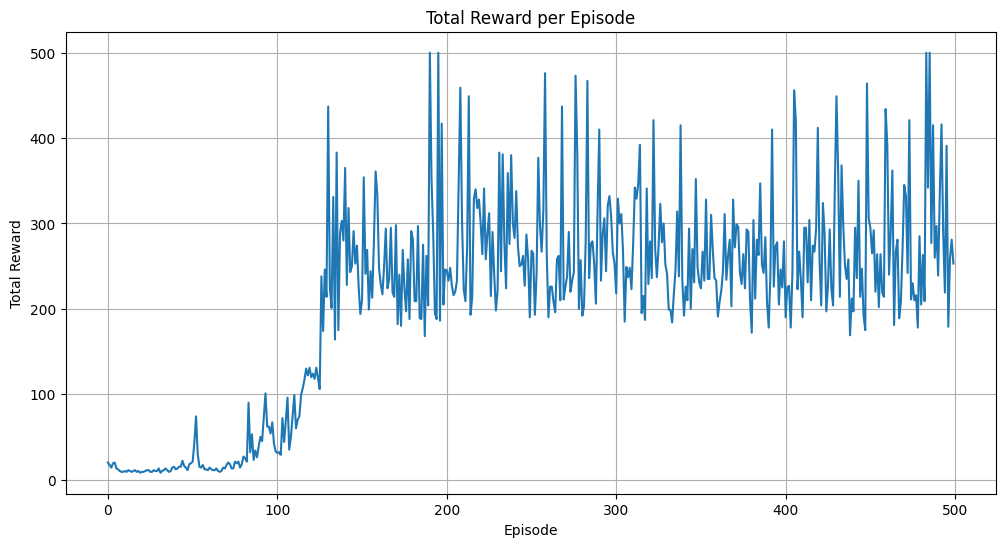

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym
import random
import matplotlib.pyplot as plt

# 1. Environment setup
env = gym.make("CartPole-v1")

# 2. DQN model layers (simple 2-layer net)
layer1 = nn.Linear(4, 128)
layer2 = nn.Linear(128, 2)

# 3. Optimizer
optimizer = optim.Adam(list(layer1.parameters()) + list(layer2.parameters()), lr=1e-3)

# 4. Replay buffer
replay_buffer = []

def store_transition(state, action, reward, next_state, done):
    replay_buffer.append((state, action, reward, next_state, done))

def sample_batch(batch_size):
    return random.sample(replay_buffer, batch_size)

# 5. Epsilon-greedy action selection
def select_action(state, epsilon):
    if random.random() < epsilon:
        return torch.tensor([random.randint(0, 1)])
    else:
        x = layer1(state)
        x = F.relu(x)
        q_values = layer2(x)
        return torch.argmax(q_values, dim=1)

# 6. Training loop with reward tracking
num_episodes = 500
gamma = 0.99
batch_size = 32
all_rewards = []

for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        state_tensor = torch.tensor([state], dtype=torch.float32)

        # Select action (epsilon decays over episodes)
        epsilon = max(0.01, 0.1 - 0.01 * (episode / 200))
        action = select_action(state_tensor, epsilon)
        action_value = action.item()

        # Take action in environment
        next_state, reward, terminated, truncated, _ = env.step(action_value)
        done = terminated or truncated
        next_state_tensor = torch.tensor([next_state], dtype=torch.float32)

        # Store experience
        store_transition(state_tensor.squeeze(0), action_value, reward, next_state_tensor.squeeze(0), done)

        # Move to next state
        state = next_state
        total_reward += reward

        # Train if enough data
        if len(replay_buffer) >= batch_size:
            batch = sample_batch(batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)

            # Convert to tensors
            states      = torch.stack(states)                             # [batch_size, 4]
            actions     = torch.tensor(actions).unsqueeze(1)              # [batch_size, 1]
            rewards     = torch.tensor(rewards).unsqueeze(1)              # [batch_size, 1]
            next_states = torch.stack(next_states)                        # [batch_size, 4]
            dones       = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)  # [batch_size, 1]

            # Predicted Q-values for current states
            q1 = layer1(states)
            q1 = F.relu(q1)
            q_values = layer2(q1)
            q_pred = q_values.gather(1, actions)  # Q(s, a)

            # Compute Bellman target Q-values
            with torch.no_grad():
                q2 = layer1(next_states)
                q2 = F.relu(q2)
                next_q_values = layer2(q2)
                max_next_q = next_q_values.max(1)[0].unsqueeze(1)
                target = rewards + gamma * max_next_q * (1 - dones)

            # Compute loss
            loss_fn = nn.MSELoss()
            loss = loss_fn(q_pred, target)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    all_rewards.append(total_reward)
    print(f"Episode {episode+1}: Total Reward = {total_reward}")

# 7. Plot total rewards over episodes
plt.figure(figsize=(12, 6))
plt.plot(all_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.grid(True)
plt.show()

# 8. Save the trained model
torch.save({
    'layer1_state_dict': layer1.state_dict(),
    'layer2_state_dict': layer2.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'cartpole_dqn_model.pth')
